# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
import sys
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [3]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [4]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [5]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

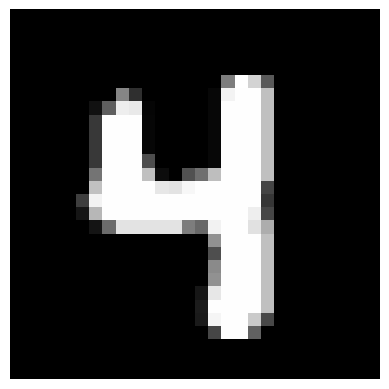

In [6]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [7]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [8]:
t_data = train_data[:50000, :] #training set
t_labels = train_labels[:50000] #training set labels
vt_data = train_data[-10000: , :] #validation training set
vt_labels = train_labels[-10000:] #validation training labels

In [9]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
   
    for label in range(k): #data for each class
        x_class = x[y == label] # only selecting rows that are true for y==label
        pi[label] = len(x_class)/len(x) #probability by getting the length of that class vs all classes
        mu[label] = np.mean(x_class, axis=0) #mean across each class(column)
        sigma[label] = np.cov(x_class.T) #using the np.cov needs n_samples and n_features
    # create a list of Gaussian distributions for each label
    #gaussians = [multivariate_normal(mean=mu[i], cov=sigma[i]) for i in range(k)]
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

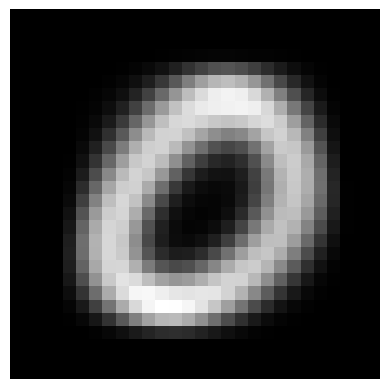

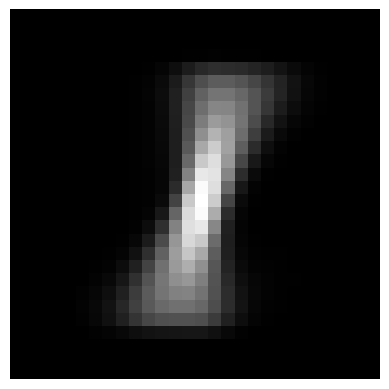

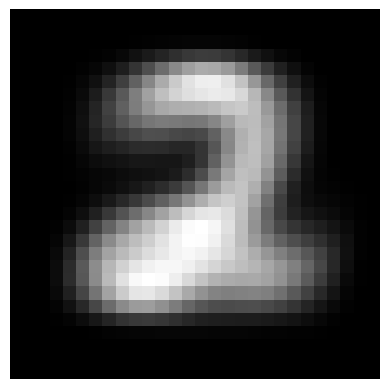

In [10]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

In [11]:
c_values = [1e-2, 1, 1e2,1e3, 1e4, 1e5, 1e10] 
#train Gaussian model w/different c's 
models=[]
for c in c_values:
    model = GaussianMixture(n_components=10, covariance_type='full', 
                            reg_covar = c)
    model.fit(vt_data)
    models.append(model)
for i, model in enumerate(models):
    y_pred = model.predict(test_data)
    print(f'c={c_values[i]}:')
    print(f'Accuracy: {accuracy_score(test_labels, y_pred)}')
    print(f'Precision: {precision_score(test_labels, y_pred, average="macro")}')
    print(f'Recall: {recall_score(test_labels, y_pred, average="macro")}')
    print(f'F1-score: {f1_score(test_labels, y_pred, average="macro")}')

c=0.01:
Accuracy: 0.1357
Precision: 0.14653297239830762
Recall: 0.12796316077052958
F1-score: 0.13100016488711283
c=1:
Accuracy: 0.1346
Precision: 0.12951111050635516
Recall: 0.1359177543201893
F1-score: 0.1257039872899967
c=100.0:
Accuracy: 0.0427
Precision: 0.04737968421283656
Recall: 0.0447675662589766
F1-score: 0.044564722642612103
c=1000.0:
Accuracy: 0.0516
Precision: 0.06401368378005041
Recall: 0.05164792595076928
F1-score: 0.05665497196552928
c=10000.0:
Accuracy: 0.0323
Precision: 0.06531449864429868
Recall: 0.032755385358618425
F1-score: 0.04031115080347495
c=100000.0:
Accuracy: 0.0958
Precision: 0.09822676900637897
Recall: 0.09485296216758063
F1-score: 0.08277131229957185
c=10000000000.0:
Accuracy: 0.1135
Precision: 0.01135
Recall: 0.1
F1-score: 0.0203861697350696


c:\users\mary0\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the previous test, we will be using c = 100 for the regularization of the matrices. This value was chosen due to its accuracy among the other c-values. (The code changed accuracy later. )

In [12]:
# before continuing, we received a singular matrix error so we will try to fix it by cI (c - constant & I - identity matrix)
# we will use validation set to find c
def fit_generative_model2(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    c = 100
   
    for label in range(k): #data for each class
        x_class = x[y == label] # only selecting rows that are true for y==label
        pi[label] = len(x_class)/len(x) #probability by getting the length of that class vs all classes
        mu[label] = np.mean(x_class, axis=0) #mean across each class(column)
        sigma[label] = np.cov(x_class.T) + c*np.identity(d) #using the np.cov needs n_samples and n_features
    # create a list of Gaussian distributions for each label
    #gaussians = [multivariate_normal(mean=mu[i], cov=sigma[i]) for i in range(k)]
    return mu, sigma, pi

In [13]:
mu,sigma,pi = fit_generative_model2(t_data, t_labels)

In [14]:
# Baye's Rule
# P(c|x) = (P(x|c) * P(c)) 
def classify_new_image(x_bayes):
    k = 10  # labels 0,1,...,k-1
    likelihood = np.zeros(k) #P(x|c)
    for label in range(k):
        likelihood[label] = multivariate_normal.pdf(x_bayes , mean = mu[label] , cov=sigma[label])
        posterior = likelihood * pi[label] #P(c|x)
        prediction = np.argmax(posterior) #pi j *Pj is largest
        return posterior

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [15]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print ("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 801 errors out of 10000


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> Pseucode for your training procedure, making it clear how the validation set was created and used. 

<font color="blue">1:</font> Notes were left during the code to make it useful for others to understand what is going on. The process was dividing our training set into two sets called t_data and vt_data. We then finished the function of fit_generative_model which gives us the pi, mu and sigma. However, we had a singular matrix problem, so we used the validation data to find a c. This was done by training a model using GaussianMixture, and finding the c with the highest accuracy and F1 score. This c was determine to be 100, and it was then used for fit_generative_model2 which did the same as fit_generative_model but it regularized matrices by adding cI to sigma or covariances. Lastly, we created a function using Baye's rule called classify_new_image, and we lastly tested our model by using log pi + logPi(x). We found that the model made 801 errors out of 10000. This is an error rate of 8.01%. 

<font color="magenta">Exercise 2:</font> Did you use a single value of c for all ten classes, or seperate values for each class? What value(s) of c did you get?

<font color="blue"> 2:</font> The value for c was the same for all ten classes, and it was c =1e2 or c=100. The accuracy changed the last time I ran the models, but I still kept the same c-value since the error rate was the same. 

<font color="magenta">Exercise 3:</font> What was the error rate on the MNIST test set?

<font color="blue"> 3:</font> The error rate was 8.01% on the test set.

<font color="magenta"> Exercise 4:</font>: Out of the misclassified test digits, pick five ar eandome and display them. For each instance, list the posterior probabilities Pr(y|x) of each of the ten classes.

In [16]:
incorrect_idx = np.where(predictions != test_labels)
print(incorrect_idx);

(array([  18,   59,   61,   73,   80,   97,  111,  119,  133,  151,  175,
        182,  195,  198,  211,  217,  220,  221,  240,  241,  247,  259,
        264,  275,  282,  289,  320,  321,  333,  335,  340,  349,  352,
        359,  362,  376,  397,  421,  425,  443,  444,  445,  448,  460,
        468,  469,  478,  479,  495,  497,  508,  511,  515,  519,  520,
        540,  542,  551,  571,  583,  605,  610,  613,  619,  624,  628,
        631,  659,  666,  667,  669,  684,  689,  691,  699,  717,  720,
        726,  728,  740,  741,  760,  771,  785,  791,  797,  829,  846,
        857,  866,  876,  877,  895,  898,  906,  924,  939,  944,  947,
        950,  956,  958,  965,  976,  978,  982, 1003, 1012, 1014, 1017,
       1022, 1024, 1032, 1039, 1055, 1062, 1072, 1082, 1087, 1088, 1096,
       1101, 1107, 1112, 1114, 1133, 1145, 1152, 1153, 1166, 1169, 1173,
       1182, 1204, 1206, 1208, 1212, 1216, 1226, 1228, 1232, 1233, 1242,
       1247, 1258, 1260, 1270, 1283, 1289, 1299, 1

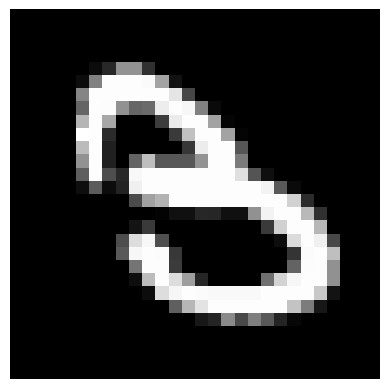

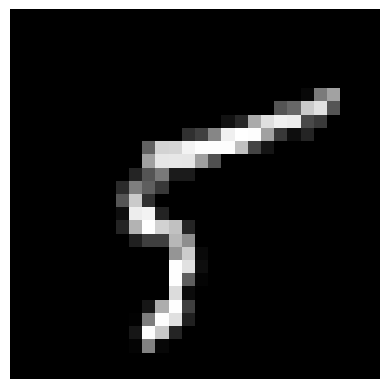

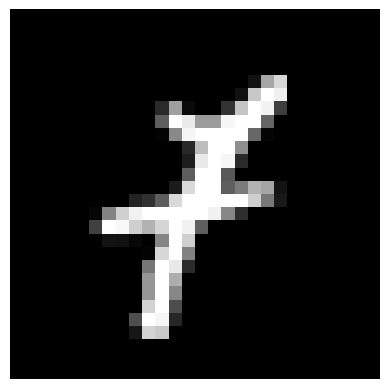

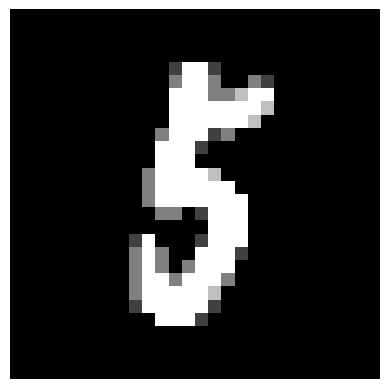

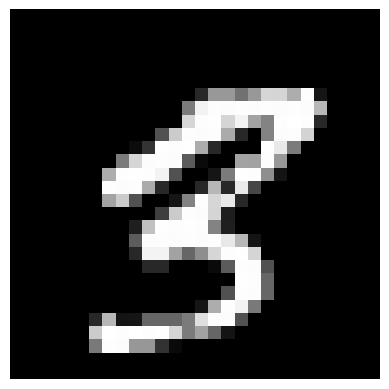

In [17]:
displaychar(test_data[18])
displaychar(test_data[59])
displaychar(test_data[3838])
displaychar(test_data[4356])
displaychar(test_data[9944])

In [18]:
misclassified_digits = test_data[ [18, 59, 3838, 4356, 9944],:]

In [19]:
row_indices = [18, 59, 3838, 4356, 9944]
selected_rows = score[row_indices, :]
selected = np.argmax(selected_rows, axis=1)

In [20]:
#posterior probabilities of the 5 digits randomly chosen
selected

array([2, 8, 8, 8, 8], dtype=int64)